<a href="https://colab.research.google.com/github/ror2000/Ecom-Dashboard-ML-Insights/blob/main/E_Commerce_Customer_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Extract the data

In [1]:
# Import Google Drive and mount it to access files
from google.colab import drive
drive.mount('/content/drive')

# Define the file path for the dataset stored in Google Drive
file_path = "/content/drive/My Drive/E-commerce_data2.xlsx"

# Import necessary libraries for data processing, visualization, and machine learning
import pandas as pd  # For data manipulation
from sklearn.preprocessing import LabelEncoder  # For encoding categorical data
import seaborn as sns  # For data visualization
import matplotlib.pyplot as plt  # For plotting
import numpy as np  # For numerical operations
from sklearn.neighbors import NearestNeighbors  # For nearest neighbor analysis
from sklearn.cluster import DBSCAN  # For clustering
from sklearn.metrics import silhouette_score  # For evaluating clustering performance
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

# Load the Excel file into a Pandas ExcelFile object
xls = pd.ExcelFile(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Display the names of all sheets in the Excel file
xls.sheet_names

['customers', 'genders', 'cities', 'transactions', 'branches', 'merchants']

In [3]:
# Read each table from the excel file
customers = xls.parse("customers")
genders = xls.parse("genders")
cities = xls.parse("cities")
transactions = xls.parse("transactions")
branches = xls.parse("branches")
merchants = xls.parse("merchants")

# View the shape of each table to verify the data.
print(customers.shape)
print(genders.shape)
print(cities.shape)
print(transactions.shape)
print(branches.shape)
print(merchants.shape)

(1000, 4)
(2, 2)
(20, 2)
(5000, 7)
(10, 2)
(20, 2)


# Merge the Data

In [4]:
customers.head(5)

,customer_id,join_date,city_id,gender_id
0,1,2022-01-08,7,1
1,2,2023-05-02,20,2
2,3,2023-05-14,15,1
3,4,2022-11-25,11,2
4,5,2023-04-26,8,1


In [5]:
# Merge the customers dataset with genders (on gender_id) and cities (on city_id) to add descriptive labels
dataset_customers = customers.merge(genders, on="gender_id").merge(cities, on="city_id")

# Display the first 5 rows of the merged dataset
dataset_customers.head(5)

,customer_id,join_date,city_id,gender_id,gender_name,city_name
0,1,2022-01-08,7,1,Male,Mansoura
1,2,2023-05-02,20,2,Female,Sohag
2,3,2023-05-14,15,1,Male,Aswan
3,4,2022-11-25,11,2,Female,Ismailia
4,5,2023-04-26,8,1,Male,El-Mahalla El-Kubra


The dataset now includes customer details along with gender and city names, making it easier to interpret and analyze.

In [6]:
transactions.head(5)

,transaction_id,customer_id,transaction_date,transaction_status,coupon_name,burn_date,branch_id
0,1,733,2024-05-11,subscribed,uNY-568,NaT,7
1,2,631,2023-05-15,burned,kBx-219,2023-06-04,5
2,3,309,2022-11-13,subscribed,PLG-122,NaT,7
3,4,695,2024-01-26,subscribed,Wzf-897,NaT,2
4,5,288,2022-10-12,burned,qGb-428,2022-11-20,6


In [7]:
# Merge the transactions dataset with branches (on branch_id) and merchants (on merchant_id) to add relevant details
dataset_transactions = transactions.merge(branches, on="branch_id").merge(merchants, on="merchant_id")

# Display the first 5 rows of the merged dataset
dataset_transactions.head(5)

,transaction_id,customer_id,transaction_date,transaction_status,coupon_name,burn_date,branch_id,merchant_id,merchant_name
0,1,733,2024-05-11,subscribed,uNY-568,NaT,7,7,Berry-Anderson
1,2,631,2023-05-15,burned,kBx-219,2023-06-04,5,9,"Campbell, Shaffer and Martinez"
2,3,309,2022-11-13,subscribed,PLG-122,NaT,7,7,Berry-Anderson
3,4,695,2024-01-26,subscribed,Wzf-897,NaT,2,18,Lewis LLC
4,5,288,2022-10-12,burned,qGb-428,2022-11-20,6,15,Butler-Gomez


The dataset now includes transaction details along with branch and merchant names, making it easier to analyze transaction trends and merchant activity.

In [8]:
# Merge the transactions dataset with the customers dataset using customer_id to combine transaction and customer details
dataset = dataset_transactions.merge(dataset_customers, on="customer_id")

# Display the first 5 rows of the merged dataset
dataset.head(5)

,transaction_id,customer_id,transaction_date,transaction_status,coupon_name,burn_date,branch_id,merchant_id,merchant_name,join_date,city_id,gender_id,gender_name,city_name
0,1,733,2024-05-11,subscribed,uNY-568,NaT,7,7,Berry-Anderson,2023-05-16,15,2,Female,Aswan
1,2,631,2023-05-15,burned,kBx-219,2023-06-04,5,9,"Campbell, Shaffer and Martinez",2022-10-10,14,2,Female,Damietta
2,3,309,2022-11-13,subscribed,PLG-122,NaT,7,7,Berry-Anderson,2022-05-30,2,1,Male,Alexandria
3,4,695,2024-01-26,subscribed,Wzf-897,NaT,2,18,Lewis LLC,2023-11-27,15,2,Female,Aswan
4,5,288,2022-10-12,burned,qGb-428,2022-11-20,6,15,Butler-Gomez,2021-09-04,14,1,Male,Damietta


The dataset now combines transaction data with customer details, including gender and city, allowing for deeper analysis of customer behavior and spending patterns.

In [9]:
dataset.shape

(5000, 14)

#Explore the data

In [10]:
print(dataset.shape)
dataset.head(5)

(5000, 14)


,transaction_id,customer_id,transaction_date,transaction_status,coupon_name,burn_date,branch_id,merchant_id,merchant_name,join_date,city_id,gender_id,gender_name,city_name
0,1,733,2024-05-11,subscribed,uNY-568,NaT,7,7,Berry-Anderson,2023-05-16,15,2,Female,Aswan
1,2,631,2023-05-15,burned,kBx-219,2023-06-04,5,9,"Campbell, Shaffer and Martinez",2022-10-10,14,2,Female,Damietta
2,3,309,2022-11-13,subscribed,PLG-122,NaT,7,7,Berry-Anderson,2022-05-30,2,1,Male,Alexandria
3,4,695,2024-01-26,subscribed,Wzf-897,NaT,2,18,Lewis LLC,2023-11-27,15,2,Female,Aswan
4,5,288,2022-10-12,burned,qGb-428,2022-11-20,6,15,Butler-Gomez,2021-09-04,14,1,Male,Damietta


In [11]:
dataset.dtypes

,0
transaction_id,int64
customer_id,int64
transaction_date,datetime64[ns]
transaction_status,object
coupon_name,object
burn_date,datetime64[ns]
branch_id,int64
merchant_id,int64
merchant_name,object
join_date,datetime64[ns]


In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   transaction_id      5000 non-null   int64         
 1   customer_id         5000 non-null   int64         
 2   transaction_date    5000 non-null   datetime64[ns]
 3   transaction_status  5000 non-null   object        
 4   coupon_name         5000 non-null   object        
 5   burn_date           2516 non-null   datetime64[ns]
 6   branch_id           5000 non-null   int64         
 7   merchant_id         5000 non-null   int64         
 8   merchant_name       5000 non-null   object        
 9   join_date           5000 non-null   datetime64[ns]
 10  city_id             5000 non-null   int64         
 11  gender_id           5000 non-null   int64         
 12  gender_name         5000 non-null   object        
 13  city_name           5000 non-null   object      

In [13]:
dataset.describe()

,transaction_id,customer_id,transaction_date,burn_date,branch_id,merchant_id,join_date,city_id,gender_id
count,5000.000000,5000.000000,5000,2516,5000.000000,5000.000000,5000,5000.000000,5000.00000
mean,2500.500000,509.551600,2023-10-22 04:38:47.040000,2023-12-01 20:39:06.581876224,5.529800,12.882600,2023-01-18 14:41:34.080000,10.091800,1.48660
min,1.000000,1.000000,2021-08-05 00:00:00,2021-08-14 00:00:00,1.000000,7.000000,2021-07-18 00:00:00,1.000000,1.00000
25%,1250.750000,262.000000,2023-05-31 18:00:00,2023-07-12 00:00:00,3.000000,9.000000,2022-04-10 00:00:00,5.000000,1.00000
50%,2500.500000,514.000000,2024-01-02 00:00:00,2024-02-11 00:00:00,6.000000,13.000000,2023-01-11 00:00:00,10.000000,1.00000
75%,3750.250000,758.000000,2024-05-08 00:00:00,2024-06-18 00:00:00,8.000000,15.000000,2023-10-25 00:00:00,15.000000,2.00000
max,5000.000000,1000.000000,2024-07-14 00:00:00,2024-10-08 00:00:00,10.000000,20.000000,2024-07-13 00:00:00,20.000000,2.00000
std,1443.520003,287.065172,NaN,NaN,2.895788,4.000452,NaN,5.860703,0.49987


In [14]:
dataset.isnull().sum()

,0
transaction_id,0
customer_id,0
transaction_date,0
transaction_status,0
coupon_name,0
burn_date,2484
branch_id,0
merchant_id,0
merchant_name,0
join_date,0


In [15]:
# Iterate through each column in the dataset
for col in dataset.columns:
    # Print the column name and the number of unique values in it
    print(col, ':', dataset[col].nunique())

    # Print the top 5 most frequent values in the column
    print(dataset[col].value_counts().nlargest(5))

    # Print a separator for better readability
    print('\n' + '*' * 20 + '\n')

transaction_id : 5000
transaction_id
1       1
3331    1
3338    1
3337    1
3336    1
Name: count, dtype: int64

********************

customer_id : 989
customer_id
822    14
726    13
833    12
776    12
471    12
Name: count, dtype: int64

********************

transaction_date : 885
transaction_date
2024-07-12    43
2024-07-02    33
2024-07-13    33
2024-07-10    32
2024-07-06    32
Name: count, dtype: int64

********************

transaction_status : 2
transaction_status
burned        2516
subscribed    2484
Name: count, dtype: int64

********************

coupon_name : 5000
coupon_name
uNY-568    1
lCa-763    1
JCY-213    1
DSY-050    1
xFH-194    1
Name: count, dtype: int64

********************

burn_date : 789
burn_date
2024-07-24    13
2024-07-30    13
2024-07-23    13
2024-08-03    12
2024-05-01    12
Name: count, dtype: int64

********************

branch_id : 10
branch_id
1     527
10    526
6     507
9     506
7     496
Name: count, dtype: int64

********************

mer

In [16]:
dataset.describe(include='object')

,transaction_status,coupon_name,merchant_name,gender_name,city_name
count,5000,5000,5000,5000,5000
unique,2,5000,8,2,20
top,burned,uNY-568,Thomas-Nelson,Male,Cairo
freq,2516,1,1032,2567,337


In [17]:
dataset.duplicated().sum()

0

#Data cleaning

In [18]:
# Drop the specified columns from the dataset as they are no longer needed for analysis
dataset = dataset.drop(columns=["transaction_id", "branch_id", "merchant_id", "city_id", "gender_id"])

In [19]:
# Create a new column 'is_burned' where 1 indicates that the 'burn_date' is not missing (i.e., the coupon was burned) and 0 indicates it was not
dataset["is_burned"] = dataset["burn_date"].notna().astype(int)

In [20]:
# Create a new column 'gender_numeric' by mapping 'Male' to 0 and 'Female' to 1 for numerical representation of gender
dataset["gender_numeric"] = dataset["gender_name"].map({"Male": 0, "Female": 1})

In [21]:
# Create a new column 'total_transactions' that counts the number of transactions for each customer
dataset['total_transactions'] = dataset.groupby('customer_id')['transaction_date'].transform('count')

In [22]:
# Create a new column 'burned_coupons' that sums the number of burned coupons for each customer
dataset['burned_coupons'] = dataset.groupby('customer_id')['is_burned'].transform('sum')

In [23]:
# Create a new column 'burned_ratio' that calculates the ratio of burned coupons to total transactions for each customer
dataset['burned_ratio'] = dataset['burned_coupons'] / dataset['total_transactions']

In [24]:
# Initialize the LabelEncoder and use it to encode the 'city_name' column into numerical values
label_encoder = LabelEncoder()
dataset["city_numeric"] = label_encoder.fit_transform(dataset["city_name"])

In [25]:
print(dataset.shape)
dataset.head(5)

(5000, 15)


,customer_id,transaction_date,transaction_status,coupon_name,burn_date,merchant_name,join_date,gender_name,city_name,is_burned,gender_numeric,total_transactions,burned_coupons,burned_ratio,city_numeric
0,733,2024-05-11,subscribed,uNY-568,NaT,Berry-Anderson,2023-05-16,Female,Aswan,0,1,7,3,0.428571,1
1,631,2023-05-15,burned,kBx-219,2023-06-04,"Campbell, Shaffer and Martinez",2022-10-10,Female,Damietta,1,1,7,5,0.714286,6
2,309,2022-11-13,subscribed,PLG-122,NaT,Berry-Anderson,2022-05-30,Male,Alexandria,0,0,3,0,0.000000,0
3,695,2024-01-26,subscribed,Wzf-897,NaT,Lewis LLC,2023-11-27,Female,Aswan,0,1,5,4,0.800000,1
4,288,2022-10-12,burned,qGb-428,2022-11-20,Butler-Gomez,2021-09-04,Male,Damietta,1,0,7,4,0.571429,6


In [26]:
# Group the dataset by 'customer_id' and calculate the total number of transactions and burned coupons for each customer
customer_usage = dataset.groupby("customer_id").agg(
    total_transactions=("transaction_date", "count"),
    burned_coupons=("is_burned", "sum")
    ).reset_index()

# Calculate the 'burned_ratio' for each customer by dividing burned coupons by total transactions
customer_usage["burned_ratio"] = customer_usage["burned_coupons"] / customer_usage["total_transactions"]

# Print the shape of the resulting dataframe (rows and columns)
print(customer_usage.shape)

# Display the first 10 rows of the customer_usage dataframe
customer_usage.head(10)

(989, 4)


,customer_id,total_transactions,burned_coupons,burned_ratio
0,1,7,3,0.428571
1,2,3,1,0.333333
2,3,5,1,0.200000
3,4,1,0,0.000000
4,5,4,3,0.750000
5,6,4,4,1.000000
6,7,4,2,0.500000
7,8,7,2,0.285714
8,10,8,5,0.625000
9,11,2,0,0.000000


In [27]:
customer_usage.describe()

,customer_id,total_transactions,burned_coupons,burned_ratio
count,989.000000,989.000000,989.000000,989.000000
mean,500.672396,5.055612,2.543984,0.504979
std,288.338824,2.273759,1.557058,0.255910
min,1.000000,1.000000,0.000000,0.000000
25%,251.000000,3.000000,1.000000,0.333333
50%,500.000000,5.000000,2.000000,0.500000
75%,751.000000,6.000000,4.000000,0.666667
max,1000.000000,14.000000,8.000000,1.000000


#EDA

In [28]:
dataset.describe()

,customer_id,transaction_date,burn_date,join_date,is_burned,gender_numeric,total_transactions,burned_coupons,burned_ratio,city_numeric
count,5000.000000,5000,2516,5000,5000.00000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000
mean,509.551600,2023-10-22 04:38:47.040000,2023-12-01 20:39:06.581876224,2023-01-18 14:41:34.080000,0.50320,0.48660,6.077200,3.039200,0.503200,9.328800
min,1.000000,2021-08-05 00:00:00,2021-08-14 00:00:00,2021-07-18 00:00:00,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000
25%,262.000000,2023-05-31 18:00:00,2023-07-12 00:00:00,2022-04-10 00:00:00,0.00000,0.00000,5.000000,2.000000,0.375000,4.000000
50%,514.000000,2024-01-02 00:00:00,2024-02-11 00:00:00,2023-01-11 00:00:00,1.00000,0.00000,6.000000,3.000000,0.500000,9.000000
75%,758.000000,2024-05-08 00:00:00,2024-06-18 00:00:00,2023-10-25 00:00:00,1.00000,1.00000,8.000000,4.000000,0.666667,14.000000
max,1000.000000,2024-07-14 00:00:00,2024-10-08 00:00:00,2024-07-13 00:00:00,1.00000,1.00000,14.000000,8.000000,1.000000,19.000000
std,287.065172,NaN,NaN,NaN,0.50004,0.49987,2.264214,1.608161,0.219337,5.676754


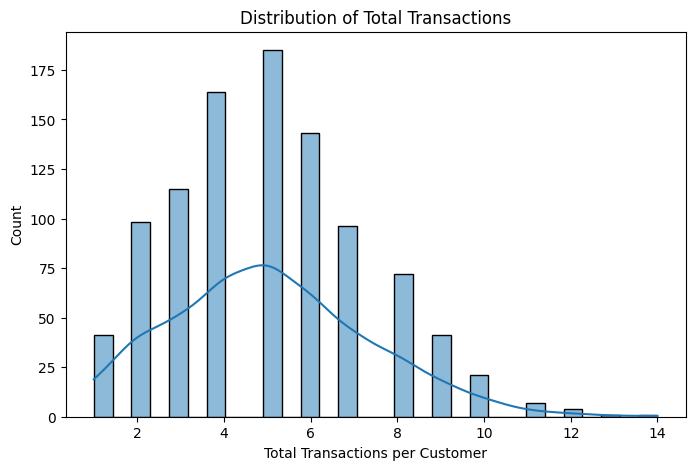

In [29]:
# Set the figure size for the plot
plt.figure(figsize=(8, 5))

# Create a histogram with a Kernel Density Estimate (KDE) to show the distribution of total transactions per customer
sns.histplot(customer_usage["total_transactions"], bins=30, kde=True)

# Set the labels for the x-axis and y-axis
plt.xlabel("Total Transactions per Customer")
plt.ylabel("Count")

# Set the title of the plot
plt.title("Distribution of Total Transactions")

# Display the plot
plt.show()

The histogram indicates that most customers have 2 to 6 transactions, with frequency peaking around 4 transactions and declining sharply for higher counts.

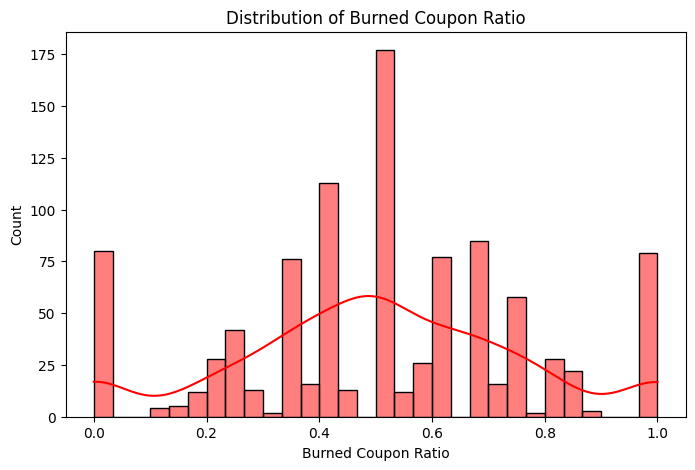

In [30]:
# Set the figure size for the plot
plt.figure(figsize=(8, 5))

# Create a histogram with a Kernel Density Estimate (KDE) to show the distribution of burned coupon ratio per customer
sns.histplot(customer_usage["burned_ratio"], bins=30, kde=True, color='red')

# Set the labels for the x-axis and y-axis
plt.xlabel("Burned Coupon Ratio")
plt.ylabel("Count")

# Set the title of the plot
plt.title("Distribution of Burned Coupon Ratio")

# Display the plot
plt.show()


The histogram shows that most burned coupon ratios are concentrated around 0.0 to 0.4, indicating that a significant portion of coupons are either not used or have a low redemption rate.

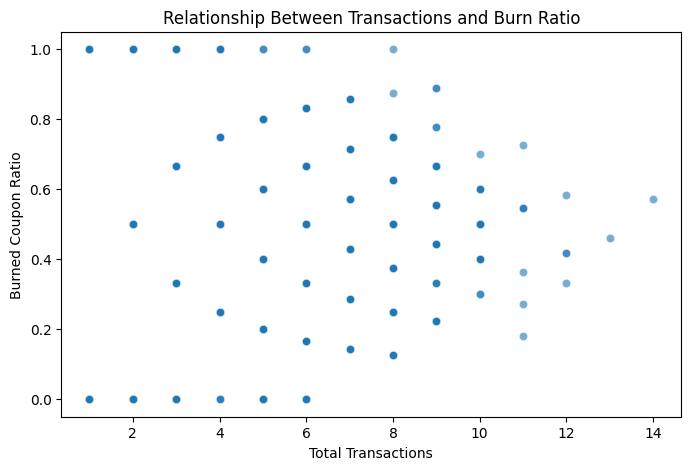

In [31]:
# Set the figure size for the scatter plot
plt.figure(figsize=(8, 5))

# Create a scatter plot to show the relationship between total transactions and burned coupon ratio
sns.scatterplot(x=customer_usage["total_transactions"], y=customer_usage["burned_ratio"], alpha=0.6)

# Set the labels for the x-axis and y-axis
plt.xlabel("Total Transactions")
plt.ylabel("Burned Coupon Ratio")

# Set the title of the plot
plt.title("Relationship Between Transactions and Burn Ratio")

# Display the plot
plt.show()

The scatter plot indicates a weak or negligible relationship between the number of total transactions and the burn ratio, suggesting that higher transaction counts do not significantly impact coupon redemption rates.

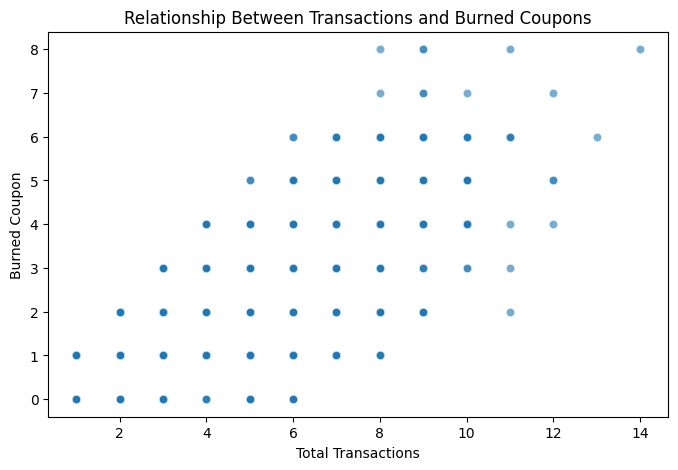

In [32]:
# Set the figure size for the scatter plot
plt.figure(figsize=(8, 5))

# Create a scatter plot to show the relationship between total transactions and burned coupons
sns.scatterplot(x=customer_usage["total_transactions"], y=customer_usage["burned_coupons"], alpha=0.6)

# Set the labels for the x-axis and y-axis
plt.xlabel("Total Transactions")
plt.ylabel("Burned Coupon")

# Set the title of the plot
plt.title("Relationship Between Transactions and Burned Coupons")

# Display the plot
plt.show()

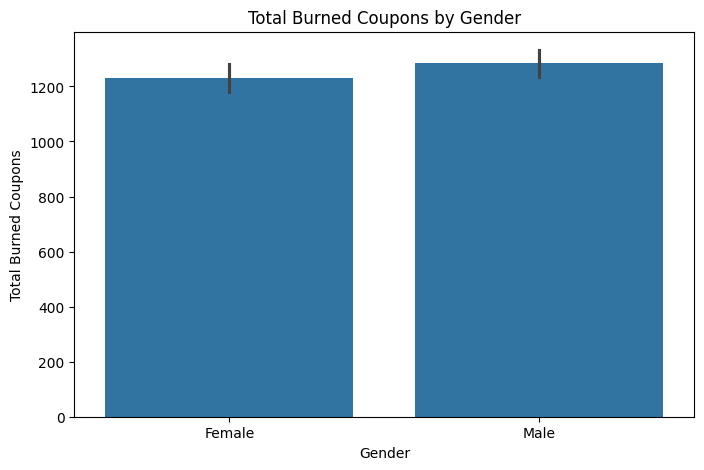

In [33]:
# Set the figure size for the bar plot
plt.figure(figsize=(8, 5))

# Create a bar plot to show the total burned coupons by gender
sns.barplot(x=dataset["gender_name"], y=dataset["is_burned"], estimator=lambda x: x.sum())

# Set the labels for the x-axis and y-axis
plt.xlabel("Gender")
plt.ylabel("Total Burned Coupons")

# Set the title of the plot
plt.title("Total Burned Coupons by Gender")

# Display the plot
plt.show()

The bar chart indicates that males have a higher total number of burned coupons compared to females, suggesting greater coupon usage among male customers.

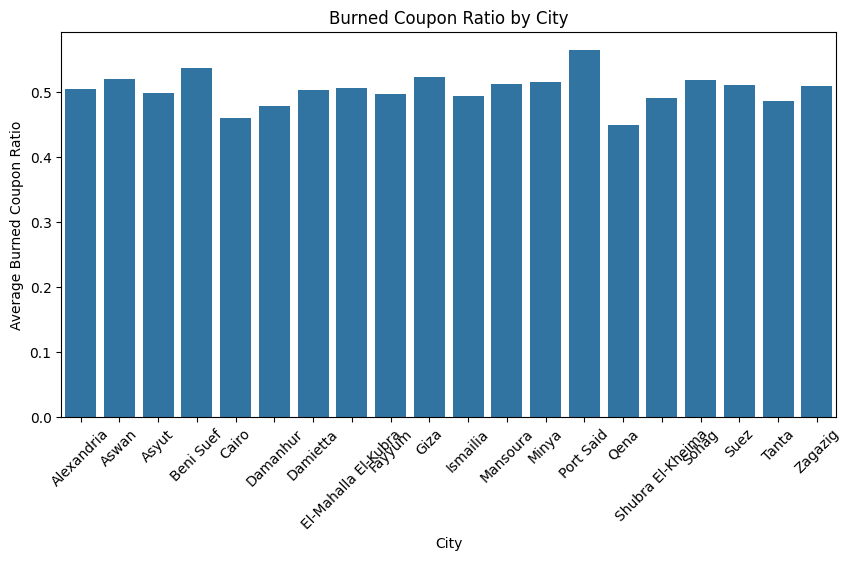

In [34]:
# Set the figure size for the bar plot
plt.figure(figsize=(10, 5))

# Create a bar plot to show the average burned coupon ratio by city
sns.barplot(x=dataset.groupby("city_name")["is_burned"].mean().index,
            y=dataset.groupby("city_name")["is_burned"].mean().values)

# Set the labels for the x-axis and y-axis
plt.xlabel("City")
plt.ylabel("Average Burned Coupon Ratio")

# Set the title of the plot
plt.title("Burned Coupon Ratio by City")

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

The bar chart shows variations in the average burned coupon ratio across different cities, indicating that coupon redemption rates differ by location.

#Model Training and Evaluation

In [35]:
customer_usage.head()

,customer_id,total_transactions,burned_coupons,burned_ratio
0,1,7,3,0.428571
1,2,3,1,0.333333
2,3,5,1,0.200000
3,4,1,0,0.000000
4,5,4,3,0.750000


In [36]:
# Select specific columns ('total_transactions', 'burned_coupons', 'burned_ratio') from the customer_usage dataframe to create a new dataframe X
X = customer_usage[['total_transactions', 'burned_coupons', 'burned_ratio']]

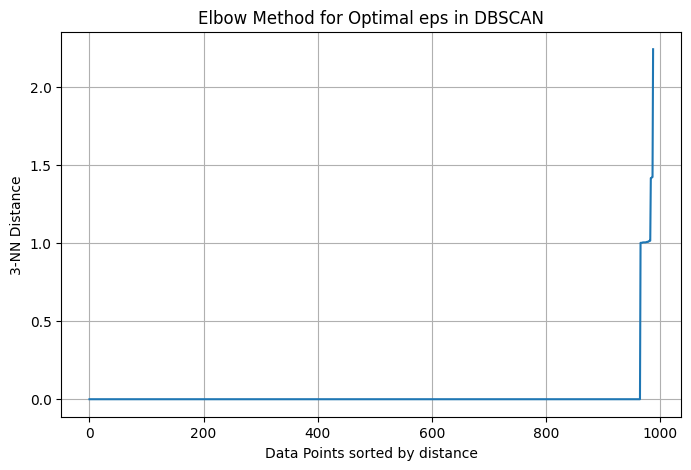

In [37]:
# Set the number of neighbors for the NearestNeighbors algorithm
k = 3

# Fit the NearestNeighbors model on the selected features (X) and calculate the nearest neighbors
nbrs = NearestNeighbors(n_neighbors=k).fit(X)
distances, indices = nbrs.kneighbors(X)

# Sort the distances of the k-th nearest neighbors
k_distances = np.sort(distances[:, k-1])

# Set the figure size for the plot
plt.figure(figsize=(8, 5))

# Plot the sorted k-th nearest neighbor distances to apply the elbow method for DBSCAN
plt.plot(k_distances)

# Set the labels for the x-axis and y-axis
plt.xlabel("Data Points sorted by distance")
plt.ylabel(f"{k}-NN Distance")

# Set the title of the plot
plt.title("Elbow Method for Optimal eps in DBSCAN")

# Add a grid to the plot for better visualization
plt.grid()

# Display the plot
plt.show()

In [38]:
# Initialize the DBSCAN model with the specified epsilon (eps) and minimum samples for a cluster
dbscan = DBSCAN(eps=1, min_samples=3)

# Apply the DBSCAN algorithm to the selected features (X) and assign cluster labels to each customer
customer_usage['cluster'] = dbscan.fit_predict(X)

# Print the first few rows of the customer_usage dataframe with the new 'cluster' column
print(customer_usage.head())

   customer_id  total_transactions  burned_coupons  burned_ratio  cluster
0            1                   7               3      0.428571        0
1            2                   3               1      0.333333        1
2            3                   5               1      0.200000        2
3            4                   1               0      0.000000        3
4            5                   4               3      0.750000        4


In [39]:
# Calculate the silhouette score to evaluate the quality of the clustering
score = silhouette_score(X, customer_usage['cluster'])

# Print the silhouette score to assess the clustering performance
print(f'Silhouette Score: {score}')

Silhouette Score: 0.8659897621542652


A silhouette score of 0.87 indicates good clustering, with well-separated and distinct groups.

In [40]:
# Check if there are any rows with cluster label -1 (indicating noise points in DBSCAN)
if (customer_usage['cluster'] == -1).any():
    # Count the number of rows with cluster label -1
    num_rows_with_minus_one = (customer_usage['cluster'] == -1).sum()

    # Print the number of rows with cluster label -1
    print(f"Number of rows with cluster -1: {num_rows_with_minus_one}")

Number of rows with cluster -1: 23


There are 23 rows with cluster label -1, indicating 23 noise points in the DBSCAN clustering.

In [41]:
customer_usage.describe()

,customer_id,total_transactions,burned_coupons,burned_ratio,cluster
count,989.000000,989.000000,989.000000,989.000000,989.000000
mean,500.672396,5.055612,2.543984,0.504979,14.839232
std,288.338824,2.273759,1.557058,0.255910,10.435528
min,1.000000,1.000000,0.000000,0.000000,-1.000000
25%,251.000000,3.000000,1.000000,0.333333,4.000000
50%,500.000000,5.000000,2.000000,0.500000,15.000000
75%,751.000000,6.000000,4.000000,0.666667,23.000000
max,1000.000000,14.000000,8.000000,1.000000,40.000000


The "cluster" column has values ranging from -1 to 40, with a mean of 14.84. The minimum value of -1 indicates noise points identified by DBSCAN, while the maximum value of 40 suggests a large number of distinct clusters.

In [42]:
# Filter the customer_usage dataframe to show only customers with more than 10 total transactions
customer_usage[customer_usage['total_transactions'] > 10]

,customer_id,total_transactions,burned_coupons,burned_ratio,cluster
69,73,12,5,0.416667,-1
150,154,11,6,0.545455,33
152,156,11,3,0.272727,-1
465,471,12,5,0.416667,-1
488,494,11,8,0.727273,-1
566,573,11,6,0.545455,33
716,726,13,6,0.461538,-1
766,776,12,4,0.333333,-1
773,783,11,6,0.545455,33
812,822,14,8,0.571429,-1


The filtered data shows customers with more than 10 transactions. Some are labeled as noise (-1), while others belong to cluster 33. The burned coupon ratio varies among them.

In [43]:
# Filter the customer_usage dataframe to show only customers that are labeled as noise (cluster == -1)
customer_usage[customer_usage['cluster'] == -1]

,customer_id,total_transactions,burned_coupons,burned_ratio,cluster
55,59,10,7,0.700000,-1
69,73,12,5,0.416667,-1
96,100,5,5,1.000000,-1
105,109,10,3,0.300000,-1
107,111,8,7,0.875000,-1
152,156,11,3,0.272727,-1
222,226,5,5,1.000000,-1
223,227,9,7,0.777778,-1
439,445,9,7,0.777778,-1
465,471,12,5,0.416667,-1


The filtered data shows customers labeled as noise (cluster == -1). These customers have a wide range of burned coupon ratios and total transactions, with some having very high ratios (close to 1) and others with lower values.

In [44]:
# Count the number of occurrences of each unique cluster label in the 'cluster' column
customer_usage['cluster'].value_counts()

,count
cluster,
3,80
19,68
6,67
24,58
4,48
12,47
23,40
1,38
22,38


Most customers are grouped into larger clusters, with clusters 3, 19, and 6 being the most frequent. The noise cluster (-1) contains 23 customers, indicating some outliers, while several smaller clusters have fewer customers.

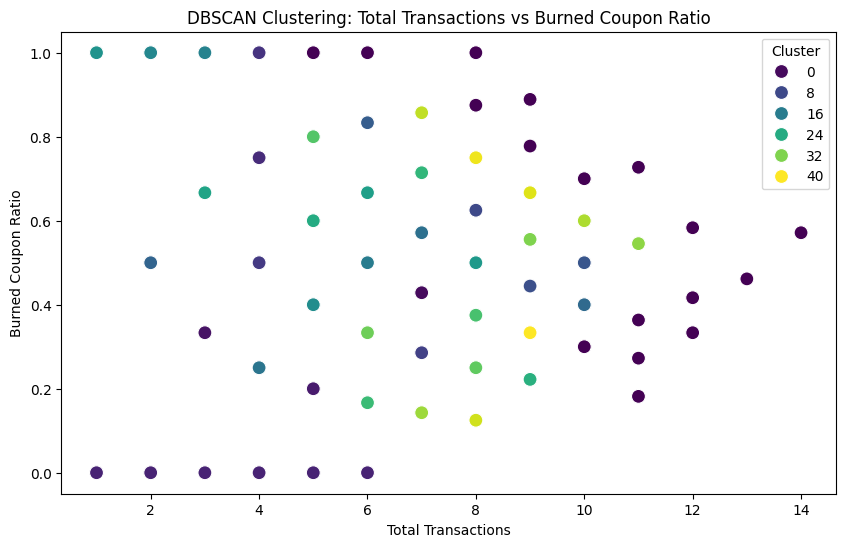

In [45]:
# Set the figure size for the scatter plot
plt.figure(figsize=(10, 6))

# Create a scatter plot with total transactions on the x-axis and burned coupon ratio on the y-axis
# Points are colored based on their cluster label using the 'viridis' color palette
sns.scatterplot(
    x='total_transactions',
    y='burned_ratio',
    hue='cluster',  # Color points by their cluster label
    data=customer_usage,  # Use the customer_usage dataframe
    palette='viridis',  # Choose the color palette
    s=100  # Set the size of the points
)

# Set the title of the plot
plt.title('DBSCAN Clustering: Total Transactions vs Burned Coupon Ratio')

# Set labels for the x-axis and y-axis
plt.xlabel('Total Transactions')
plt.ylabel('Burned Coupon Ratio')

# Display the legend with the title 'Cluster'
plt.legend(title='Cluster')

# Display the plot
plt.show()

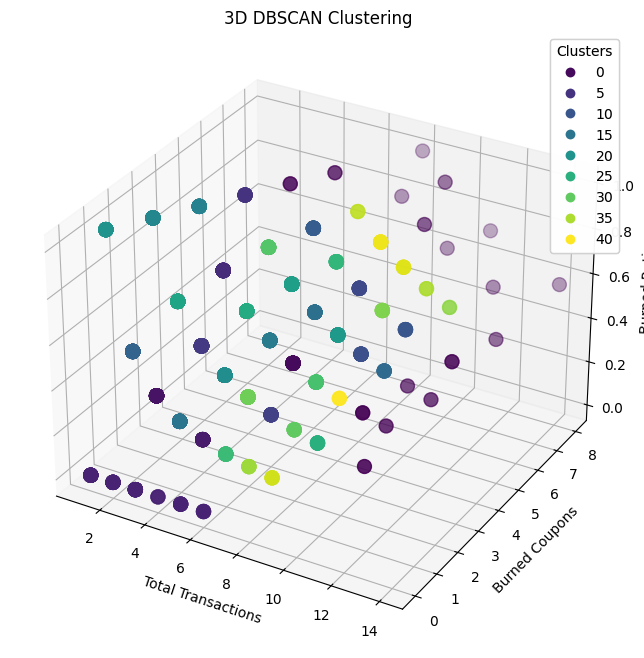

In [46]:
# Create a 3D plot with a larger figure size
fig = plt.figure(figsize=(10, 8))

# Add a 3D subplot to the figure
ax = fig.add_subplot(111, projection='3d')

# Create a scatter plot in 3D with the following dimensions:
# - 'total_transactions' on the x-axis
# - 'burned_coupons' on the y-axis
# - 'burned_ratio' on the z-axis
# Color the points based on their cluster labels and use the 'viridis' color palette
scatter = ax.scatter(
    customer_usage['total_transactions'],
    customer_usage['burned_coupons'],
    customer_usage['burned_ratio'],
    c=customer_usage['cluster'],
    cmap='viridis',
    s=100
)

# Set labels for the x, y, and z axes
ax.set_xlabel('Total Transactions')
ax.set_ylabel('Burned Coupons')
ax.set_zlabel('Burned Ratio')

# Set the title of the 3D plot
ax.set_title('3D DBSCAN Clustering')

# Add a legend for the clusters
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

# Display the plot
plt.show()